In [1]:
# Step 1: Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np


# Ensure complete dataset
data = pd.read_csv('Dispense.csv')

# Convert caldate to datetime
data['caldate'] = pd.to_datetime(data['caldate'], format='%d-%m-%Y')

# Handle missing values
data.ffill(inplace=True)


# Display the first few rows of the dataset
data.head()


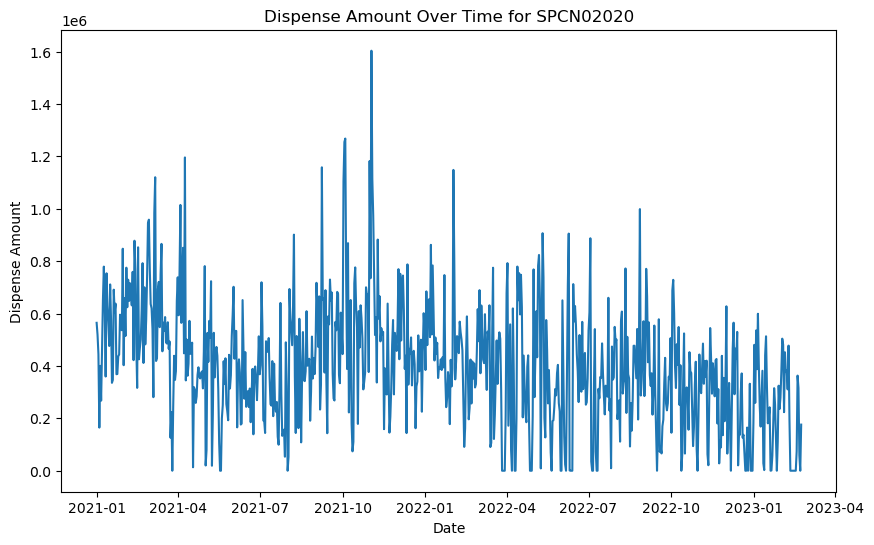

In [3]:
# Step 2: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Dispense amount over time for a sample ATM
sample_atm = data[data['ATMID'] == 'SPCN02020']
plt.figure(figsize=(10, 6))
plt.plot(sample_atm['caldate'], sample_atm['Dispense'])
plt.title('Dispense Amount Over Time for SPCN02020')
plt.xlabel('Date')
plt.ylabel('Dispense Amount')
plt.show()

In [4]:
# Summary statistics
data.describe()

,caldate,Dispense,DT,MaxCapacity,CountTotalTxn
count,14593,1.459300e+04,14593.000000,1.459300e+04,14593.000000
mean,2022-02-24 13:07:26.762146304,4.027993e+05,158.538614,3.279753e+06,105.322963
min,2021-01-01 00:00:00,0.000000e+00,0.000000,2.420000e+06,0.000000
25%,2021-08-28 00:00:00,1.685000e+05,0.000000,2.860000e+06,45.000000
50%,2022-03-07 00:00:00,3.653000e+05,0.000000,3.520000e+06,98.000000
75%,2022-09-02 00:00:00,5.780000e+05,64.000000,3.520000e+06,146.000000
max,2023-02-22 00:00:00,2.151800e+06,1440.000000,3.740000e+06,561.000000
std,NaN,3.036762e+05,356.073765,3.974770e+05,76.727151


# data.select_dtypes(include=[np.number]) filters the DataFrame data to include only columns with numeric data types (such as int64, float64, etc.).
# np.number is a shorthand for selecting all numeric types in NumPy.
# This step ensures that any columns containing strings or other non-numeric types are excluded, preventing conversion errors during correlation calculation.

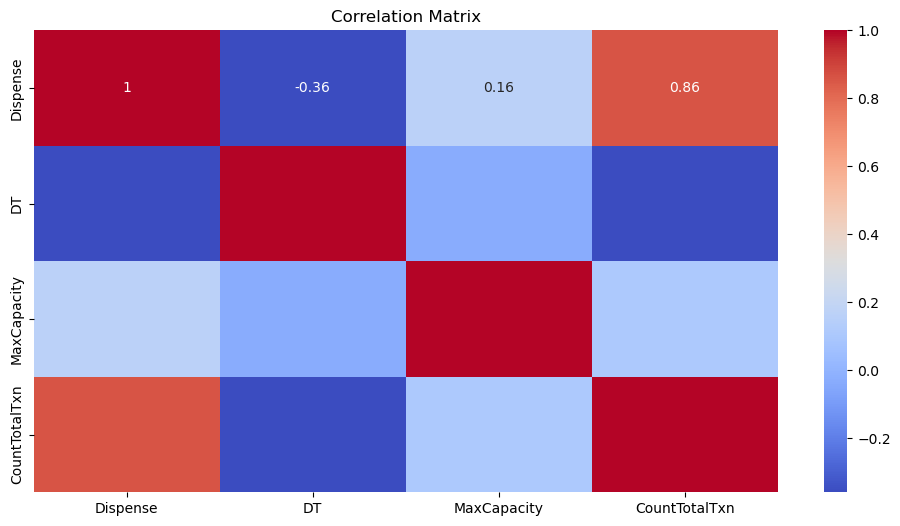

In [5]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [6]:
## Step 3: Feature Engineering

# Create lag features
data['Dispense_Lag1'] = data.groupby('ATMID')['Dispense'].shift(1)
data['Dispense_Lag7'] = data.groupby('ATMID')['Dispense'].shift(7)

# Create rolling statistics
data['Dispense_RollingMean7'] = data.groupby('ATMID')['Dispense'].rolling(window=7).mean().reset_index(0, drop=True)

# Create date features
data['DayOfWeek'] = data['caldate'].dt.dayofweek
data['Month'] = data['caldate'].dt.month

# Drop NA values created by lag features
data.dropna(inplace=True)



In [7]:
#Step 4: Model Selection and Training
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Function to evaluate model
def evaluate_model(train, test, order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return mae, rmse, predictions

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Dispense'].values[:train_size], data['Dispense'].values[train_size:]

# Evaluate ARIMA model
order = (5, 1, 0)
mae, rmse, predictions = evaluate_model(train, test, order)
print(f'MAE: {mae}, RMSE: {rmse}')

In [ ]:
#Step 5: Forecasting
# Forecast for the next 7 days using the entire dataset
model = ARIMA(data['Dispense'], order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=7)
print('Forecast for the next 7 days:', forecast)

In [ ]:
# Step 6: Visualization
# Plot historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(data['caldate'], data['Dispense'], label='Historical')
plt.plot(pd.date_range(start=data['caldate'].max(), periods=8, freq='D')[1:], forecast, label='Forecast')
plt.title('ATM Dispense Forecast')
plt.xlabel('Date')
plt.ylabel('Dispense Amount')
plt.legend()
plt.show()


In [ ]:
#Step 7: Save Results

# Save forecast to CSV
forecast_df = pd.DataFrame({'Date': pd.date_range(start=data['caldate'].max(), periods=8, freq='D')[1:], 'Forecast': forecast})
forecast_df.to_csv('atm_dispense_forecast.csv', index=False)